In [72]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
from keras.layers import Input, Convolution1D, Flatten, Dense, Dropout, Embedding, Concatenate,MaxPooling1D,concatenate 
from keras.optimizers import Adam, SGD
import tensorflow as tf
import nltk 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from numpy import zeros
from nltk.tokenize import RegexpTokenizer

In [97]:
#Hyper Parameters
FILE_NAME = "../../Data/processed_data.csv"
DENSE_LAYER_SIZE =256
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.1
VERBOSE = 1
MAX_LENGTH = 861
HIDDEN_ACTIVATION_FUNCTION = 'relu'
OUTPUT_ACTIVATION_FUNCTION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS=['accuracy']
Y_LABEL_NAME="author"
X_LABEL_NAME="text"

In [98]:
#Read data
data = pd.read_csv(FILE_NAME)

In [99]:
documents = data[X_LABEL_NAME]
tokenizer = Tokenizer()

In [100]:
tokenizer.fit_on_texts(documents)

In [101]:
encoded_docs = tokenizer.texts_to_sequences(documents)


In [103]:
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
print(padded_docs)

[[   26  2954   143 ...     0     0     0]
 [   11    89   125 ...     0     0     0]
 [    7    15   145 ...     0     0     0]
 ...
 [10408  5067 15798 ...     0     0     0]
 [   17    34  4660 ...     0     0     0]
 [   13  1353     6 ...     0     0     0]]


In [104]:
max_length_for_padding=[] 
for i in encoded_docs:  
  max_length_for_padding.append(len(i))  
print(max(max_length_for_padding))

861


In [105]:
EMB_DIM = 300
w2v = Word2Vec(padded_docs,vector_size=EMB_DIM,window=5,min_count=3,negative=15)



Exception in thread Exception in thread Thread-85:
Traceback (most recent call last):
  File "c:\Python39\lib\threading.py", line 973, in _bootstrap_inner
Exception in thread Thread-86:
Traceback (most recent call last):
  File "c:\Python39\lib\threading.py", line 973, in _bootstrap_inner
Thread-84:
Traceback (most recent call last):
  File "c:\Python39\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Python39\lib\threading.py", line 910, in run
    self.run()
  File "c:\Python39\lib\threading.py", line 910, in run
    self.run()
  File "c:\Python39\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\gensim\models\word2vec.py", line 1163, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\gensim\models\word2vec.py", line 1163, in _worker_loop
    self._target(*self._args, **self._kwar

In [81]:


def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [82]:
vocab_size = len(w2v.wv)

In [83]:
word_vectors = w2v.wv

In [84]:
vocab_size

12227

In [85]:

#Defining model
def define_model(input_size, output_size, verbose = True, dense_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    


    # define model
    input =  Input(shape=(input_size,))
    emb_lay = gensim_to_keras_embedding(w2v)(input)
    #emb_lay = Embedding(vocab_size, 300,weights=[word_vectors.vectors], input_length=MAX_LENGTH, trainable=False)(input)
    conv = Convolution1D(filters = 100, kernel_size = 3, activation=hidden_activation_fn)(emb_lay)
    flat1 = Flatten()(conv)
    output=Dense(units=output_size, activation=output_activation_fn)(flat1)

    # Create model
    model = Model(inputs = [input], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = SGD(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model


 

In [86]:
#Get corpus and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [87]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [88]:
X_train= tokenizer.texts_to_sequences(text_train)
X_train =  pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')

In [89]:

X_test= tokenizer.texts_to_sequences(text_test)
X_test =  pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [90]:

#Get input and output dimensions
input_size = X_train.shape[1]
output_size = len(author.unique())

In [91]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [92]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(15663, 861)
(3916, 861)
(15663,)
(3916,)


In [93]:
# X_train = X_train[:,None]
# X_test = X_test[:,None]

# X_train = X_train[:None,]
# X_test = X_test[:None,]

In [94]:
print(np.shape(X_train))
print(np.shape(X_test))

(15663, 861)
(3916, 861)


In [95]:
# X_train = np.reshape(X_train,( -1,23230,1))
# X_test= np.reshape(X_test,( -1,23230,1))

# X_train = np.reshape(X_train,( -1,1,23230))
# X_test= np.reshape(X_test,( -1,1,23230))

In [96]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    cnn_model = define_model(input_size= input_size, output_size= output_size, verbose = False,
                      dense_layer_size = DENSE_LAYER_SIZE, hidden_activation_fn = HIDDEN_ACTIVATION_FUNCTION,
                      output_activation_fn = OUTPUT_ACTIVATION_FUNCTION, learning=LEARNING_RATE, loss_function = LOSS_FUNCTION, metrics=METRICS)

    histroy = cnn_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = cnn_model.predict(X_test)
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'model_2/embedding_2/embedding_lookup' defined at (most recent call last):
    File "c:\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\leobl\AppData\Local\Temp\ipykernel_33464\2774396768.py", line 29, in <cell line: 16>
      histroy = cnn_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\leobl\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_2/embedding_2/embedding_lookup'
indices[13,9] = 15019 is not in [0, 12227)
	 [[{{node model_2/embedding_2/embedding_lookup}}]] [Op:__inference_train_function_1849]

In [ ]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.5698842356145727
Average Precision across K-folds: 0.49052866511276466
Average Recall across K-folds: 0.5698842356145727
Average F1 Score across K-folds: 0.5113899099022093
Average Training Time across K-folds: 116.7415816783905 seconds
Prediction Time across K-folds: 1.2799992561340332 seconds


In [ ]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


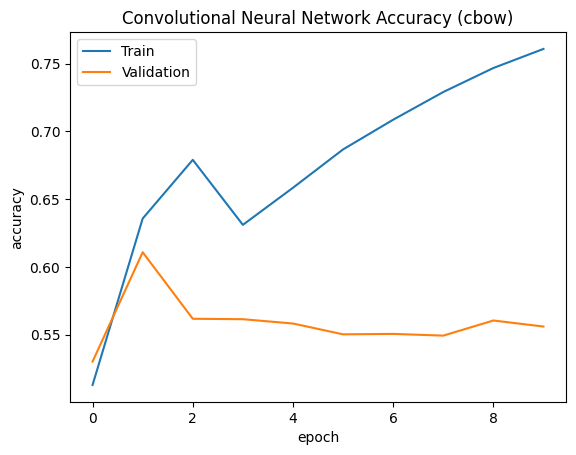

In [ ]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Convolutional Neural Network Accuracy (cbow)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network_cbow_acc.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


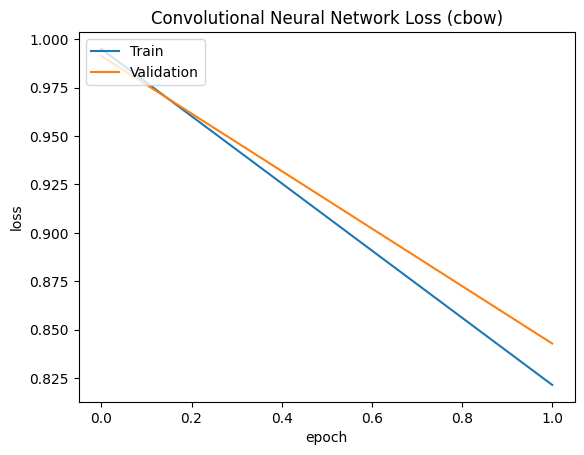

In [ ]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Convolutional Neural Network Loss (cbow)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/Convolutional_neural_network__cbow_loss.eps", format='eps')
plt.show()